# 从零开始AI - 认知服务 - 人脸识别

> ··· 您可以访问 [https://github.com/HaoHoo/F02AI](https://github.com/HaoHoo/F02AI) 来获得 “从零开始AI” 系列全部的内容。··· <br>
>`请以原样使用或转发，欢迎Issue，敬请PR；如果觉得有些意思，欢迎Fork，敬谢Star。` 

在“认知服务 - 计算机视觉”这一部分，我们介绍了使用Azure的认知服务、通过标准REST API来调用云端的人工智能服务，帮助我们实现有关的计算机智能视觉。

其实在计算机视觉中有一个非常重要的分类，就是关于人脸的识别。这个分类如此重要，以至于需要单独为其使用一套独立的REST API。对于我这个脸盲症患者来说，要是能像计算机一样又快又准确地记住识别人脸那就太好了。

按照Azure目前提供的人脸功能的分类，接下来我们可以尝试如下几种能力：
* [人脸检测](#FaceDetect)
* [人脸识别](#FaceIdentity)
* [人脸验证](#FaceVerify)

和其他认知服务一样，计算机视觉也是运行在Azure的服务。为了使用Computer Vision API，您需要一个订阅密钥 (subscription key)。别担心，您可以在[这里](https://docs.microsoft.com/azure/cognitive-services/Computer-vision/Vision-API-How-to-Topics/HowToSubscribe)获取免费的订阅密钥。或者在[这里](https://azure.microsoft.com/zh-cn/try/cognitive-services)获取试用的订阅密钥。

获取订阅密钥后，请记录密钥及分配的Azure服务区域。对于测试认知服务，往往会分配美国中西区域 (WestCentralUS)。后面我们使用这些API时，必须提供这两种信息。

要开始尝试使用计算机视觉服务分析图像，需要根据提示，输入`subscription_key` 的值，也就是前面我们获得的API密钥。

In [ ]:
subscription_key = input("Please input your Service Key:")
assert subscription_key

然后，请再次按照提示输入API密钥对应的服务区域(`westus`, `westcentralus`, 等等)。输入服务区域后，组合的对应 `vision_base_url` 显示的地址将作为服务API调用的终结点地址。如果使用的是免费的订阅，目前通常为 `westus`。

In [ ]:
face_base_url = input("Please input your Service Region:")
face_base_url = "https://"+face_base_url+".api.cognitive.microsoft.com/vision/v2.0/"

## 使用Python调用Face API进行人脸检测 <a name="FaceDetect"> </a>

在 [Face Detect](https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395236) API网站，您能够直接在页面查看图像分析所支持的方法。该 API 网站非常便利，除了查阅 API 方法之外，您还可以直接尝试提供图片测试该 API。调用该API可选择使用这些参数：`faceId`，`landmarks`和`attributes`。

如果调用成功，API 将返回以下信息:
年龄(`age`)，性别(`gender`)，姿势(`headPose`)，微笑(`smile`)，美发(`facialHair`)，眼镜(`glasses`)，情感(`emotion`)，头发(`hair`)，化妆(`makeup`)，遮挡(`occlusion`)，配件(`accessories`)，模糊(`blur`)，曝光(`exposure`)和噪声(`noise`)。
不需要全部信息的时候，`attibutes`可以指定返回上述信息的子集。

照片放在微软的云端，会不会侵犯隐私？可以放心的是，存放的是提取的面部特征而不是实际图像。前面提及的`faceId`就是面部特征的标识符，它将用于各类人脸功能，并在API调用后24小时过期。

实际上，人脸检测方法是Face API最为基础的方法。因为其他方法所需要使用的faceId，都需要通过Face Detect方法来获取。

我们先把一些需要的库文件导入到代码环境。通过在notebook中使用“魔术”代码，可以在线导入matplotlib来进行画图。我们就用这个库来”画“出提供的照片。

In [ ]:
%matplotlib inline
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import requests

先来一个有意思的人脸检测的实验：您有信心一眼看出几十人的合影中，有多少男性、多少女性吗？让我们找一张合影尝试一下。

In [ ]:
image_url = "https://github.com/HaoHoo/F02AI/raw/master/N02/images/Face/mvp-l.jpg"
image = Image.open(BytesIO(requests.get(image_url).content))
plt.figure(figsize=(10,10))
plt.imshow(image)
_ = plt.axis("off")

在我们还没有数完有多少个人头的时候，人工智能已经完成了所有人脸的检测分析。简单的代码，就能够把女性使用紫色、男性使用蓝色标记出来。当然，以下的代码只是显示处理之后的照片。

In [ ]:
image_url = "https://github.com/HaoHoo/F02AI/raw/master/N02/images/Face/mvp-d.jpg"
image = Image.open(BytesIO(requests.get(image_url).content))
plt.figure(figsize=(10,10))
plt.imshow(image)
_ = plt.axis("off")

实际上，使用前面提供的图片是无法完成人脸检测的。因为图片的分辨率不够。人脸检测对面部图片的建议为：正面，清晰，脸部大小为200x200像素（眼睛间为100像素）或更大。
用于人脸检测的图片支持JPEG，PNG，GIF（第一帧）和BMP格式。允许的图像文件大小为1KB到6MB。当面部尺寸为36x36到4096x4096像素时，可以检测到面部。如果需要检测非常小而清晰的面部，请尝试放大输入图像。图像最多可返回64个面。面部按面部矩形大小从大到小排列。人脸检测更喜欢正面和近正面，否则可能会无法识别出人脸。

### 分析图像

人脸检测的URL调用链接形如以下的例子 (可以在[这里](https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395236)查看REST API文档):

<code>https://[location].api.cognitive.microsoft.com/face/v1.0/<b>detect</b>[?returnFaceId][&returnFaceLandmarks][&returnFaceAttributes][&recognitionModel][&returnRecognitionModel]</code>

所以URL后面调用的功能先设置为 `detect`。

In [ ]:
face_detect_url = face_base_url + "detect"

要开始分析图像，我们需要提供一张图片的URL给 `image_url` 变量。当然，您也可以把照片的URL改为您期望的地址。

In [ ]:
image_url = "https://downtrend.com/wp-content/uploads/2018/06/twa2.jpg"
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)

为了通过 REST 方式调用人脸检测的 `detect` API，接下来的代码块需要使用 Python 的 `requests` 库。API 调用的结果将以 JSON 对象返回。按照规范，变量 `headers` 使用一个 dictionary 类型来包含必要的 API 密钥信息。而变量 `params` 同样使用 dictionary 类型来定义要调用的可视化功能。所有支持的功能都可以访问 [REST API 文档](https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395236)查看。

接着就可以通过 `requests` 来调用 REST 并返回 JSON 形式的结果了。

In [ ]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key }
params   = {'returnFaceAttributes': 'age,gender,smile,facialHair,glasses,emotion,\
hair,makeup,occlusion,accessories,blur,exposure,noise',
            'recognitionModel': 'recognition_02'}
data     = {'url': image_url}
response = requests.post(face_detect_url, headers=headers, params=params, json=data)
response.raise_for_status()
analysis = response.json()

让我们来看一下人脸检测功能成功运行之后，返回了什么信息。

In [ ]:
print(analysis)

可以看到，人脸检测识别出了照片中的人脸，并且给出了一些关于人脸的信息。例如，人脸检测判断说这是一位58岁的男性，金发，没戴眼镜。并且还发现了识别出的人脸正在笑。让我们再来一张照片，来比较一下返回的信息差异～

In [ ]:
image_url = "http://news.eastday.com/w/20140314/images/02468061.jpg"
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)

然后我们跟前一张照片一样，调用人脸检测功能来看看返回的信息。

In [ ]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key }
params   = {'returnFaceAttributes': 'age,gender,smile,facialHair,glasses,emotion,\
hair,makeup,occlusion,accessories,blur,exposure,noise',
            'recognitionModel': 'recognition_02'}
data     = {'url': image_url}
response = requests.post(face_detect_url, headers=headers, params=params, json=data)
response.raise_for_status()
analysis = response.json()
print(analysis)

这一次返回的信息有所不同。首先，人脸检测判断这是位42岁的男性，戴了眼镜。我们还看到，这次识别的人脸比较严肃，没有笑。

那么，Azure中的人脸检测服务是如何识别人脸以及其他信息的呢？

实际上，计算机对人脸上的27个特征点进行了标记。利用这些特征点，计算机能够识别出这是否是人脸，并且，对照这些特征点的相对位置，计算机通过机器学习，就能够识别人脸的表情。在后面的实验，我们会单独介绍表情识别。

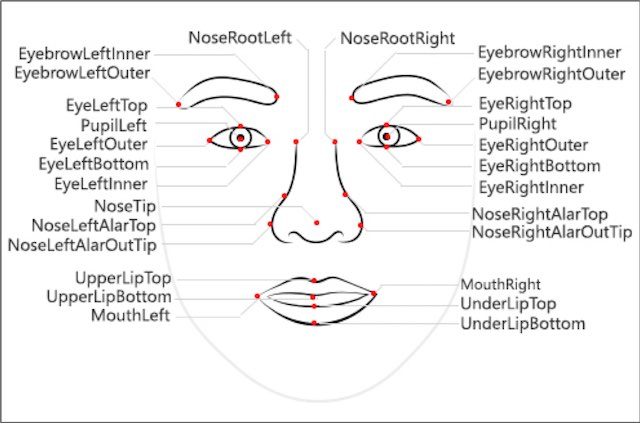

我们可以来尝试获得一下这些特征点。还是一样，我们找一张照片。

In [ ]:
#image_url = "http://p.ananas.chaoxing.com/star2/2014-06/1024_0c/1403711159370jpizg.jpg"
image_url = "http://e0.ifengimg.com/02/2018/1115/DD191588DA10D452E6583743AB6E68749E5F8D14_size153_w1447_h961.jpeg"
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)

如人脸检测的REST API文档描述，我们需要构造调用的HTTP头部信息和参数，然后使用服务终结点URL来POST数据，再处理返回的数据。

In [ ]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key }
params   = {'returnFaceLandmarks': 'true'}
data     = {'url': image_url}
response = requests.post(face_detect_url, headers=headers, params=params, json=data)
response.raise_for_status()
analysis = response.json()
print(analysis)

让我们把人脸检测识别的面部区域和面部特征的27个点的坐标从JSON数据中筛选出来。

In [ ]:
detect_face = analysis[0]["faceRectangle"]
print(detect_face)
points_face = analysis[0]["faceLandmarks"]
print(points_face)

数据看起来很乱对吧？让我们把数据整理一下。

In [ ]:
import pandas as pd
df = pd.DataFrame(points_face).T
print(df)

通过将JSON数据转化为Data Frame，并且将其进行矩阵转置，我们终于获得了看上去比较舒服的面部特征点数据集合。
细心的你也许发现返回的特征点名称和前文的图有点差异？这是因为微软在2019年03月更新了认知服务，在Face API的各功能调用中，提供了了新的参数'recognitionModel'。支持的'recognitionModel'值包括“recognition_01”或“recognition_02”。默认值为“recognition_01”。建议使用“recognition_02”，因为与“recognition_01”相比，它的整体精度得到了提高。需要注意的是两个不同版本的模型不可以混用。

接下来，我们把这些数据画到照片上，方便对照查看。

In [ ]:
from matplotlib.patches import Rectangle
plt.figure(figsize=(8,16))
ax     = plt.imshow(image, alpha=0.7)
origin = (detect_face["left"], detect_face["top"])
p      = Rectangle(origin, detect_face["width"], detect_face["height"], fill=False, linewidth=2, color='blue')
ax.axes.add_patch(p)
plt.scatter(df.x, df.y, s=5, c='navy')
_ = plt.axis("off")

实际上，前面我们看到的计算机视觉帮助判断表情的信息，也是通过对这些特征点建模来实现的。表情对于人脸检测非常重要，很多人也许不会通过语言直接表露自己的情绪，但是却经常由表情显露出真实的情绪。

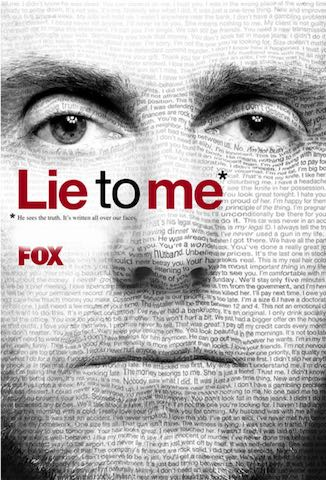

甚至FBI都出过有关微表情判断人的行为的书，还有比较有意思的电视剧。所以我们可以来尝试两个例子。
识别表情并不需要特别的API功能，因为已经合并到Face API了。我们来尝试一下。

In [ ]:
image_url = "https://github.com/HaoHoo/F02AI/raw/master/N02/images/Face/bqb01.jpg"
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)

我们把这个表情包图片发送给人脸认知服务。

In [ ]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key }
params   = {'returnFaceAttributes': 'emotion',
            'recognitionModel': 'recognition_02'}
data     = {'url': image_url}
response = requests.post(face_detect_url, headers=headers, params=params, json=data)
response.raise_for_status()
analysis = response.json()
print(analysis)

返回的信息比较不容易读，我们来做一些转换。

In [ ]:
import numpy as np
import pandas as pd
emotion_data=analysis[0]['faceAttributes']
print(emotion_data)
emotion_lenth = 8
emotion_labels = np.array(['anger','contempt','disgust','fear','happiness','neutral','sadness','surprise'])
print(emotion_labels)
emotion_rate=pd.DataFrame(emotion_data)
emotion_rate=np.array(emotion_rate)
emotion_rate=np.ravel(emotion_rate)
print(emotion_rate)

现在，数据被分为标签和表情概率两个数组，我们来尝试用雷达图显示检测出的综合表情。

In [ ]:
angles = np.linspace(0, 2*np.pi, emotion_lenth, endpoint=False)
emotion_show = np.concatenate((emotion_rate, [emotion_rate[0]])) # 闭合
angles = np.concatenate((angles, [angles[0]])) # 闭合
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, emotion_show, 'bo-', linewidth=1)# 画线
ax.fill(angles, emotion_show, facecolor='b', alpha=0.25)# 填充
ax.set_thetagrids(angles * 180/np.pi, emotion_labels)
ax.set_title("Emotion Detect", va='bottom')
ax.set_rlim(0,1)
ax.grid(True)
plt.show()

不妨再来一个例子。

In [ ]:
image_url = "https://github.com/HaoHoo/F02AI/raw/master/N02/images/Face/bqb02.jpg"
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
data     = {'url': image_url}
response = requests.post(face_detect_url, headers=headers, params=params, json=data)
response.raise_for_status()
analysis = response.json()
emotion_data=analysis[0]['faceAttributes']
print(emotion_data)
emotion_lenth = 8
emotion_labels = np.array(['anger','contempt','disgust','fear','happiness','neutral','sadness','surprise'])
print(emotion_labels)
emotion_rate=pd.DataFrame(emotion_data)
emotion_rate=np.array(emotion_rate)
emotion_rate=np.ravel(emotion_rate)
print(emotion_rate)
angles = np.linspace(0, 2*np.pi, emotion_lenth, endpoint=False)
emotion_show = np.concatenate((emotion_rate, [emotion_rate[0]])) # 闭合
angles = np.concatenate((angles, [angles[0]])) # 闭合
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, emotion_show, 'bo-', linewidth=1)# 画线
ax.fill(angles, emotion_show, facecolor='b', alpha=0.25)# 填充
ax.set_thetagrids(angles * 180/np.pi, emotion_labels)
ax.set_title("Emotion Detect", va='bottom')
ax.set_rlim(0,1)
ax.grid(True)
plt.show()

## 人脸识别 <a name="FaceIdentity"> </a>

通过人脸检测的实验，我们初步了解了对于人脸的机器视觉功能的原理——基于27的特征点来对人脸图像进行分析。既然每张面孔都可以通过这些特征点来描述，那是否可以将这个技术用于进行人脸识别呢？

答案当然是可以的。不过，要识别人脸比检测人脸就稍微复杂一点。因为我们需要对照保存的人脸图片和需要比较的人脸图片——如同我们在一些应用中使用人脸识别功能一样，首先我们需要提供几张人脸的照片给到计算机，进行特征识别、保存并让人工智能进行训练，然后才能将需要识别的人脸图片与之相对照。因此，我们必须将图片先发送给Face API并关联到人，保存这些信息用于后面的识别。

还记得前面我们介绍的FaceID吗？我们需要使用FaceID来关联这些保存的面部信息。而为了对人脸进行识别，就必须为每一个人分析几张人脸的照片。所以，我们就需要有一种组织形式，将人脸图片和人联系在一起，将人按照组进行组织。

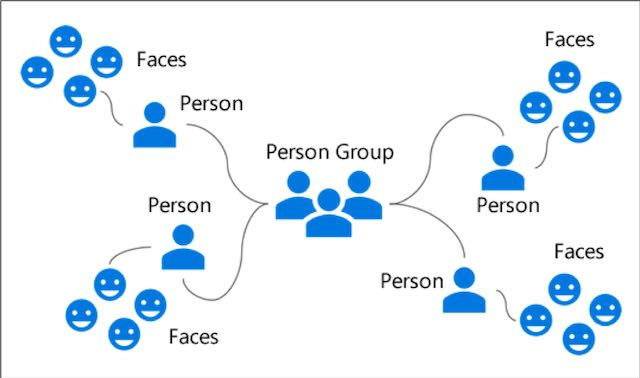

通过这种对人脸信息的组织方式，一对多识别将从人员组或大型人员组中找到特定查询人脸的最接近的匹配。我们将分为几个步骤来实现这个识别过程。

由于后面的示例代码既会使用JSON方式的HTTP Header，也会使用Octet流的，为方便使用，我们把两种Header都定义以下。

In [ ]:
json_headers = {"Ocp-Apim-Subscription-Key": subscription_key, "Content-Type": "application/json"}
octs_headers = {"Ocp-Apim-Subscription-Key": subscription_key, "Content-Type": "application/octet-stream"}
params={}

### 创建人员组

为了进行人脸识别，首先我们需要将一组人组织为一个人员组或大型人员组，随着组的创建，按照组的规模大小，也就产生了唯一的`personGroupId`或`largePersonGroupId`。

人员组限制：
* 免费订阅配额：1,000人/组。每个人最多可容纳1,000人。
* S0级订阅配额：1,000,000人/组。每个人最多可容纳10,000人。
要处理更大规模的人脸识别问题，请考虑使用 LargePersonGroup。

让我们尝试创建一个 `personGroupId` 为"msftvip"的人员组。
按照<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395244">PersonGroup - Create </a>方法的定义，调用API的URL形如：

<code>https://[location].api.cognitive.microsoft.com/face/v1.0/<b>persongroups/{personGroupId}</b></code>

而我们需要提供的HTTP Body包括 `name` 和 `userData` 两个数据。

In [ ]:
personGroupId = 'msftvip'
personGroup_create_url=face_base_url+"persongroups/"+ personGroupId
body={"name": personGroupId, "userData": "For Microsoft VIP face indentify."}
response = requests.put(personGroup_create_url, headers=json_headers, params=params, json=body)
response.raise_for_status()
print('Person Group "'+personGroupId+'" has been created.')

需要注意的是，如果试图创建已经存在的人员组，就会返回冲突的错误。这时可以选择使用已有的人员组、新建一个不同的人员组，或者对现有人员组进行删除后再创建。

### 添加人员

有了人员组之后，就可以将未来需要识别的人员添加到人员组。我们可以按照<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f3039523c">PersonGroup Person - Create</a>方法的定义，调用API的URL形如：

<code>https://[location].api.cognitive.microsoft.com/face/v1.0/persongroups/{personGroupId}/<b>persons</b></code>

可以看到，API服务URL的构造中，`persons`必须接在`persongroups/{personGroupId}`之后，所以我们必须首先创建人员组，才能将人员添加到人员组中。

我们首先来为 Satya Nadella 创建人员。通过HTTP Body传递的信息与人员组的类似，这里不复赘述。需要说明的是这里有个小花招，为了后面实验人脸验证，我们把 Satya 的`personId`做了保留。

In [ ]:
person_add_url=face_base_url+"persongroups/"+personGroupId+"/persons"

personName = "Satya Nadella"
body = {"name": personName, "userData":"Microsoft Global CEO"}
response = requests.post(person_add_url, headers=json_headers, params=params, json=body)
response.raise_for_status()
analysis = response.json()
personId = analysis.get("personId")
print('"'+personName+'" has been added to group "'+personGroupId+'". The personID: ' + personId)

verify_personId=personId

### 添加照片

人员添加完毕，该是为人员添加面部特征库的时候了。

我们可以按照<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f3039523b">PersonGroup Person - Add Face</a>方法的定义，调用API的URL形如：

<code>https://[location].api.cognitive.microsoft.com/face/v1.0/persongroups/{personGroupId}/persons/{personId}/<b>persistedFaces</b>[?userData][&targetFace]</code>

可以看到，API服务URL的构造中，`persistedFaces`必须接在`persongroups/{personGroupId}/persons/{personId}`之后，所以我们必须首先创建人员组，再创建人员，才能将人员的面部特征添加到对应人员和其所在人员组中。
为单独人员添加/删除面部特征的操作是序列的，而对不同人员添加/删除面部特征可以并行。

添加成功后，Face API会给每一张处理的面部图片一个唯一的faceId。让我们把faceId画在已经添加的照片上。

In [ ]:
face_add_url=face_base_url+"persongroups/"+ personGroupId + "/persons/" + personId + "/persistedFaces"
imageFile="images/Face/sdy01.jpg"
imageData = open(imageFile,'rb').read()
response = requests.post(face_add_url, headers=octs_headers, params=params, data=imageData)
response.raise_for_status()
analysis = response.json()
faceId = analysis.get("persistedFaceId")
image = Image.open(BytesIO(imageData))
plt.figure(figsize=(4.4, 4.4))
im = plt.imshow(image)
_ = plt.axis("off")
_ = plt.title(faceId, size="large", y=-0.12)

每个人员可以添加不超过248张面部照片进行采样保存。能够识别的像素范围如前文所提，在36x36到4096x4096像素的范围内。更高的面部图像质量意味着更好的识别精度，请考虑高质量的脸部：正面，清晰，脸部大小为200x200像素（眼睛间为100像素）或更大。

让我们继续添加两张面部照片。

In [ ]:
imageFile="images/Face/sdy02.jpg"
imageData = open(imageFile,'rb').read()
response = requests.post(face_add_url, headers=octs_headers, params=params, data=imageData)
response.raise_for_status()
analysis = response.json()
faceId = analysis.get("persistedFaceId")
image = Image.open(BytesIO(imageData))
plt.figure(figsize=(4.4, 4.4))
im = plt.imshow(image)
_ = plt.axis("off")
_ = plt.title(faceId, size="large", y=-0.12)

In [ ]:
imageFile="images/Face/sdy03.png"
imageData = open(imageFile,'rb').read()
response = requests.post(face_add_url, headers=octs_headers, params=params, data=imageData)
response.raise_for_status()
analysis = response.json()
faceId = analysis.get("persistedFaceId")
image = Image.open(BytesIO(imageData))
plt.figure(figsize=(4.4, 4.4))
im = plt.imshow(image)
_ = plt.axis("off")
_ = plt.title(faceId, size="large", y=-0.12)

接下来我们添加沈向洋博士到我们的人员组，并为他添加几张照片。

In [ ]:
personName = "XiangYang Shen"
body = {"name": personName, "userData":"Ex-Microsoft Global VP"}
response = requests.post(person_add_url, headers=json_headers, params=params, json=body)
response.raise_for_status()
analysis = response.json()
personId = analysis.get("personId")
print('"'+personName+'" has been added to group. The personID: ' + personId)

In [ ]:
face_add_url=face_base_url+"persongroups/"+ personGroupId + "/persons/" + personId + "/persistedFaces"
imageFile="images/Face/sxy01.jpg"
imageData = open(imageFile,'rb').read()
response = requests.post(face_add_url, headers=octs_headers, params=params, data=imageData)
response.raise_for_status()
analysis = response.json()
faceId = analysis.get("persistedFaceId")
image = Image.open(BytesIO(imageData))
plt.figure(figsize=(4.4, 4.4))
im = plt.imshow(image)
_ = plt.axis("off")
_ = plt.title(faceId, size="large", y=-0.12)

In [ ]:
imageFile="images/Face/sxy02.jpg"
imageData = open(imageFile,'rb').read()
response = requests.post(face_add_url, headers=octs_headers, params=params, data=imageData)
response.raise_for_status()
analysis = response.json()
faceId = analysis.get("persistedFaceId")
image = Image.open(BytesIO(imageData))
plt.figure(figsize=(4.4, 4.4))
im = plt.imshow(image)
_ = plt.axis("off")
_ = plt.title(faceId, size="large", y=-0.12)

In [ ]:
imageFile="images/Face/sxy03.jpg"
imageData = open(imageFile,'rb').read()
response = requests.post(face_add_url, headers=octs_headers, params=params, data=imageData)
response.raise_for_status()
analysis = response.json()
faceId = analysis.get("persistedFaceId")
image = Image.open(BytesIO(imageData))
plt.figure(figsize=(4.4, 4.4))
im = plt.imshow(image)
_ = plt.axis("off")
_ = plt.title(faceId, size="large", y=-0.12)

再添加潘正磊以及她的照片。

In [ ]:
personName = "ZhengLei Pan"
body = {"name": personName, "userData":"Microsoft Global VP"}
response = requests.post(person_add_url, headers=json_headers, params=params, json=body)
response.raise_for_status()
analysis = response.json()
personId = analysis.get("personId")
print('"'+personName+'" has been added to group. The personID: ' + personId)

In [ ]:
face_add_url=face_base_url+"persongroups/"+ personGroupId + "/persons/" + personId + "/persistedFaces"
imageFile="images/Face/pzl01.jpg"
imageData = open(imageFile,'rb').read()
response = requests.post(face_add_url, headers=octs_headers, params=params, data=imageData)
response.raise_for_status()
analysis = response.json()
faceId = analysis.get("persistedFaceId")
image = Image.open(BytesIO(imageData))
plt.figure(figsize=(4.4, 4.4))
im = plt.imshow(image)
_ = plt.axis("off")
_ = plt.title(faceId, size="large", y=-0.12)

In [ ]:
imageFile="images/Face/pzl02.jpg"
imageData = open(imageFile,'rb').read()
response = requests.post(face_add_url, headers=octs_headers, params=params, data=imageData)
response.raise_for_status()
analysis = response.json()
faceId = analysis.get("persistedFaceId")
image = Image.open(BytesIO(imageData))
plt.figure(figsize=(4.4, 4.4))
im = plt.imshow(image)
_ = plt.axis("off")
_ = plt.title(faceId, size="large", y=-0.12)

In [ ]:
imageFile="images/Face/pzl03.jpg"
imageData = open(imageFile,'rb').read()
response = requests.post(face_add_url, headers=octs_headers, params=params, data=imageData)
response.raise_for_status()
analysis = response.json()
faceId = analysis.get("persistedFaceId")
image = Image.open(BytesIO(imageData))
plt.figure(figsize=(4.4, 4.4))
im = plt.imshow(image)
_ = plt.axis("off")
_ = plt.title(faceId, size="large", y=-0.12)

### 训练人员组

应训练人员组/大型人员组，以便为人脸识别做好准备。可在<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395249">PersonGroup-Train</a>及<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/599ae2d16ac60f11b48b5aa4">LargePersonGroup-Train</a>文档中查看更多信息。

In [ ]:
personGroup_train_url=face_base_url+"persongroups/"+personGroupId+"/train"
response = requests.post(personGroup_train_url, headers=octs_headers, params=params, data=imageData)
response.raise_for_status()

### 识别人脸  <a href="FaceVerify"> </a>

完成训练，我们终于可以提供一张照片让人工智能来识别了。就拿之前 MVP 和 Satya 等VP合影的照片裁剪一部分出来吧。数数看，裁剪的照片中有几个人？

每次可以对包含不超过10张面部的图片进行识别。在人脸识别之前，我们需要首先使用人脸检测获得照片中的人脸信息。
为了将获得的人脸信息用于后续识别人脸的步骤，我们使用 `facesId` 来保存这个 `faceId` 列表。

In [ ]:
imageFile="images/Face/n10.jpg"
imageData = open(imageFile,'rb').read()
image = Image.open(BytesIO(imageData))
plt.figure(figsize=(10, 10))
im = plt.imshow(image)
_ = plt.axis("off")
response = requests.post(face_detect_url, headers=octs_headers, params=params, data=imageData)
response.raise_for_status()
analysis = response.json()
facesId = []
i = 0
for member in analysis:
    faceId = analysis[i].get('faceId')
    facesId.append(faceId)
    i=i+1
#print(facesId)

我们可以按照<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395239">Face - Identify</a>方法的定义，调用API的URL形如：

<code>https://[location].api.cognitive.microsoft.com/face/v1.0/<b>identify</b></code>

为了识别人脸，需要提供将要识别的人脸列表`facesID`和基于的人脸特征库——人员组`personGroupId`，因此我们需要构造一个HTTP Body包含这两个信息。

返回的候选人数受`maxNumOfCandidatesReturned`和`confidenceThreshold`的限制。如果没有人被识别，则返回的候选人将是一个空阵列。对于`faceIds`数组中的每个面部，人脸识别将计算查询面与人员组中的所有面部（由`personGroupId`给出）或大型人员组（由`largePersonGroupId`给出）之间的相似性，并返回该面部的候选人相似可信排名。

当您需要从面部列表/大型面部列表而不是人员组/大型人员组中查找相似的面部时，尝试<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395237">Face-Find Similar</a>方法，查找近似人脸。

In [ ]:
face_identify_url=face_base_url+"identify"
data = {'personGroupId': personGroupId, 'faceIds': facesId}
patams={}
response = requests.post(face_identify_url, headers=json_headers, params=params, json=data)
response.raise_for_status()
analysis = response.json()    
found = False
i = 0
for member in analysis:
    condidates = analysis[i].get('candidates')
    if condidates:
        confidence = condidates[0].get('confidence')
        personId = condidates[0].get('personId')
# Identify Person
        if confidence>0.5:
            found = True
            identifier=face_base_url+"/persongroups/"+personGroupId+"/persons/"+personId
            response = requests.get(identifier, headers=json_headers, params=params, data=body)
            response.raise_for_status()    
            identifier=response.json()
            print('Base on confidence rate:'+str(confidence)+', I found '+identifier.get('name')+' in this photo.')
    i=i+1
if not found:
    print('I don\'t know anyone in this photo.')

可以看到，人脸识别功能按照可信度条件判断出，这张照片中有Satya Nadella、XiangYang Shen、ZhengLei Pan三位微软VP。

如果只是在一堆人脸中找到相近的人脸，就不需要这么完整的人员组、人员和人脸的过程了，创建一个人脸列表(<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f3039524b">faceList</a>)，然后使用查找相似(<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395237">Face - Find Similar</a>)方法进行识别。

接下来，我们试试验证特定人脸。

## 人脸验证 <a name="FaceVerify"> </a>

验证一张人脸照片是否属于某人，需要检测这张照片获得对应的`faceId`和需要检测的人的`personId`。让我们再从网上找一张 Satya 的照片。

In [ ]:
#image_url="https://3er1viui9wo30pkxh1v2nh4w-wpengine.netdna-ssl.com/wp-content/uploads/prod/2017/09/satya-bio.png"
image_url="https://iiwisdom.com/msft-2016/wp-content/uploads/sites/121/2015/05/Satya-Nadella.jpg"
image = Image.open(BytesIO(requests.get(image_url).content))
plt.figure(figsize=(3,3))
plt.imshow(image)
_ = plt.axis("off")

再次使用Face API的Detect功能，获取这张照片的面部特征并得到`faceId`。Satya的`personId`怎么获取呢？还记得前面我们的小花招了吗？使用保存下来的verify_personId就可以了。正式编码时，可以通过对人员及人脸使用List、Get获得需要的信息，使用Update、Delete进行更新和删除。

In [ ]:
data     = {'url': image_url}
response = requests.post(face_detect_url, headers=json_headers, params=params, json=data)
response.raise_for_status()
analysis = response.json() 

verify_faceId=analysis[0].get('faceId')

face_verify_url=face_base_url+"verify"
data={"faceId": verify_faceId, "personId": verify_personId, "personGroupId": personGroupId}
response = requests.post(face_verify_url, headers=json_headers, params=params, json=data)
response.raise_for_status()
analysis = response.json() 
if analysis.get('isIdentical'):
    print ('We have '+str(analysis.get('confidence')*100)+'% sure that is Satya Nadella.')
else:
    print ('That is NOT Satya Nadella.')

为了方便继续使用现有的订阅做后续的Face API测试，在完成我们的实验后，我们可以把今天创建的人员组进行删除。

In [ ]:
#Clean up
personGroup_delete_url=face_base_url+"persongroups/"+personGroupId
bady={}
response = requests.delete(personGroup_delete_url, headers=headers, params=params, json=body)
response.raise_for_status()